In [1]:
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import joblib

notebook_root = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(notebook_root + '/../'))

from stepcovnet.configuration.parameters import SAMPLE_RATE, HOPSIZE_T
from stepcovnet.wrapper.timing_prediction import boundary_decoding, smooth_obs, get_file_scalers
from stepcovnet.common.audio_preprocessing import get_madmom_log_mels, get_madmom_librosa_features
from stepcovnet.common.utils import feature_reshape, pre_process
from madmom.features.onsets import OnsetPeakPickingProcessor

In [2]:
def get_model(multi, under, extra, pretrained, lookback=1, name=None, custom_objects={}):
    from tensorflow.keras.models import load_model
    if name is not None:
        model_name = name
    else:
        model_name = "multi_" if multi else ""
        model_name += "extra_" if extra else ""
        model_name += "time%s_" % lookback if lookback > 1 else ""
        model_name += "pretrained_" if pretrained else ""
        model_name += "timing_model"
    
    try:
        model = load_model(os.path.join('../stepcovnet', 'models', str(model_name) + '.h5'), custom_objects=custom_objects, compile=False)
    except FileNotFoundError:
        print('Model not found')
        model = None
    try:
        re_model = load_model(os.path.join('../stepcovnet', 'models', str(model_name) + '_retrained.h5'), custom_objects=custom_objects, compile=False)
    except FileNotFoundError:
        print('Retrained model not found')
        re_model = None
    
    return model, re_model

extra = False
multi = True
under = False
pretrained = False
lookback = 80
name = None

model, re_model = get_model(multi, under, extra, pretrained, lookback=lookback, name=name)

In [20]:
model.summary()

Model: "StepCOVNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
log_mel_input (InputLayer)   [(None, 80, 15, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 9, 8)          512       
_________________________________________________________________
batch_normalization (BatchNo (None, 78, 9, 8)          32        
_________________________________________________________________
activation (Activation)      (None, 78, 9, 8)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 7, 8)          584       
_________________________________________________________________
batch_normalization_1 (Batch (None, 76, 7, 8)          32        
_________________________________________________________________
activation_1 (Activation)    (None, 76, 7, 8)          0

In [38]:
test_data_dir = "../tests/data"
wav_name = 'zombie_maker.wav'
timing_name = 'zombie_maker.txt'

In [33]:
scaler = get_file_scalers("../data/", multi) 

log_mel = get_madmom_log_mels(os.path.join(test_data_dir, wav_name), 
                              SAMPLE_RATE, HOPSIZE_T, multi)

log_mel, _ = pre_process(feature_reshape(log_mel, multi), multi, scalers=scaler)

if extra:
    extra_features = get_madmom_librosa_features(os.path.join(test_data_dir, wav_name), 
                                                 SAMPLE_RATE, HOPSIZE_T, len(log_mel))
else:
    extra_features = None
    
input_data = [log_mel, extra_features] if extra else log_mel

In [34]:
pdf = model.predict(input_data, batch_size=2048)
pdf = np.squeeze(pdf)
pdf = smooth_obs(pdf)

re_pdf = re_model.predict(input_data, batch_size=2048)
re_pdf = np.squeeze(re_pdf)
re_pdf = smooth_obs(re_pdf)

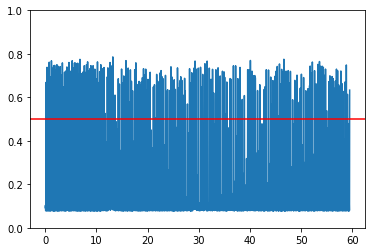

(668,) (327,)


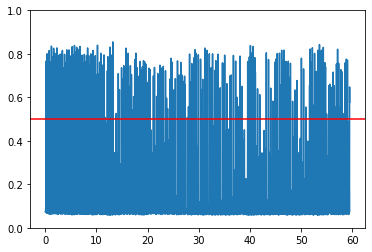

(668,) (368,)


In [42]:
def get_onsets_and_graph(pdf):
    snip = pdf[50: 60*100]
    x = np.arange(0, len(snip)) * 0.01
    plt.plot(x, snip)
    plt.axhline(y=0.5, color='r', linestyle='-')
    plt.ylim(0, 1)
    plt.show()

    onsets = boundary_decoding(obs_i=pdf, threshold=0.5)
    
    return onsets

with open(os.path.join(test_data_dir, timing_name), "r") as file:
    lines = file.readlines()
    lines = np.asarray([x.replace("\n", "").split(" ")[1] for x in lines[3:]]).astype("float")

onsets = get_onsets_and_graph(pdf)
print(lines.shape, onsets.shape)

re_onsets = get_onsets_and_graph(re_pdf)
print(lines.shape, re_onsets.shape)

In [47]:
def graph_onset_compare(pdf, onsets):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
    fig.set_size_inches(18, 8)
    start = 10
    end = 20
    snip = pdf[start * 100: end*100]
    x = np.arange(start*100, end*100) * 0.01

    ax1 = plt.subplot(211)
    ax1.plot(x, snip)
    #plt.axhline(y=0.5, color='r', linestyle='-')
    for mark in lines:
        if mark < start:
            continue
        elif mark > end:
            break
        ax1.axvline(x=mark, color= 'b')
    plt.xlim(start, end)
    plt.ylim(0, 1)

    ax2 = plt.subplot(212)
    ax2.plot(x, snip)
    #plt.axhline(y=0.5, color='r', linestyle='-')
    for mark in onsets*0.01:
        if mark < start:
            continue
        elif mark > end:
            break
        ax2.axvline(x=mark, color= 'y')
    plt.xlim(start, end)
    plt.ylim(0, 1)

    plt.show()

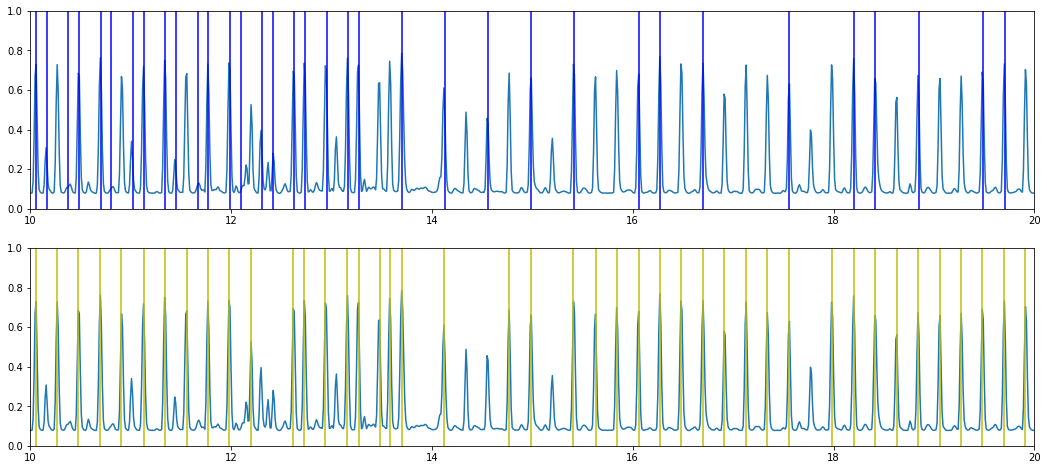

In [48]:
graph_onset_compare(pdf, onsets)

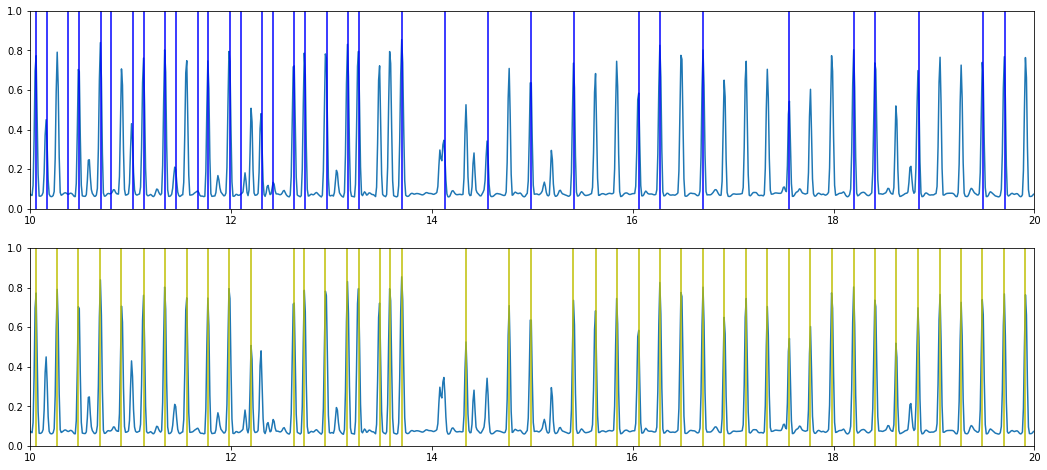

In [49]:
graph_onset_compare(re_pdf, re_onsets)

In [63]:
from sklearn.externals import joblib
pca = joblib.load('7comp_pca.pkl')

In [1]:
from sklearn.externals import joblib
pca = joblib.load('11comp_pca.pkl')

c:\users\mrchr\miniconda3\envs\tf2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [47]:
from sklearn.externals import joblib
pca = joblib.load('117comp_pca.pkl')

In [8]:
from sklearn.externals import joblib
pca = joblib.load('19_multi_comp_pca.pkl')

In [6]:
import xgboost as xgb
bst = xgb.Booster({'nthread':-1})
bst.load_model('colab_xgb_model.model')
multi = False
scaler = []
with open("training_data/under_scaler.pkl", "rb") as file:
    scaler.append(joblib.load(file))

In [ ]:
log_mel_pca = pca.transform(log_mel)

In [5]:
import xgboost as xgb
bst = xgb.Booster({'nthread':-1})
bst.load_model('colab_multi_xgb_model.model')
multi = True
scaler = []
with open("training_data/multi_under_scaler_low.pkl", "rb") as file:
    scaler.append(joblib.load(file))
with open("training_data/multi_under_scaler_mid.pkl", "rb") as file:
    scaler.append(joblib.load(file))
with open("training_data/multi_under_scaler_high.pkl", "rb") as file:
    scaler.append(joblib.load(file))

In [9]:
log_mel_pca = pca.transform(log_mel.reshape(log_mel.shape[0], log_mel.shape[1]*log_mel.shape[2]))

In [10]:
dmel = xgb.DMatrix(log_mel_pca)
pdf_xgb = bst.predict(dmel)
pdf_xgb = np.squeeze(pdf_xgb)
pdf_xgb = smooth_obs(pdf_xgb)

In [4]:
import lightgbm as lgb
lgb = lgb.Booster(model_file='colab_multi_lgb_model.model')
multi = True
scaler = []
with open("training_data/multi_under_scaler_low.pkl", "rb") as file:
    scaler.append(joblib.load(file))
with open("training_data/multi_under_scaler_mid.pkl", "rb") as file:
    scaler.append(joblib.load(file))
with open("training_data/multi_under_scaler_high.pkl", "rb") as file:
    scaler.append(joblib.load(file))

In [9]:
pdf = lgb.predict(log_mel_pca)
pdf = np.squeeze(pdf)
pdf = smooth_obs(pdf)

In [14]:
with open("colab_multi_rf_model.model", "rb") as file:
    rf = joblib.load(file)

In [17]:
pdf = rf.predict(log_mel_pca)
pdf = np.squeeze(pdf)
pdf = smooth_obs(pdf)

In [42]:
os.path.join(os.path.dirname(notebook_root), "tests", "data", wav_name)

'C:\\Users\\mrchr\\Documents\\stepcovnet\\tests\\data\\zombie_maker.wav'

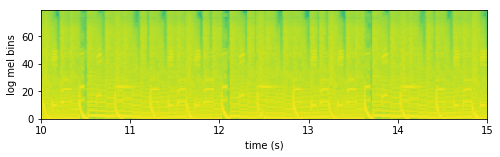

In [66]:
plt.figure(figsize=(8,2))
y = np.arange(0, 80)
x = np.arange(0, log_mel.shape[0]) * 0.01
plt.pcolormesh(x, y, np.transpose(log_mel_te[:, :, 7, 0]))
plt.ylabel('log mel bins')
plt.xlabel('time (s)')
plt.xlim(10, 15)
plt.show()

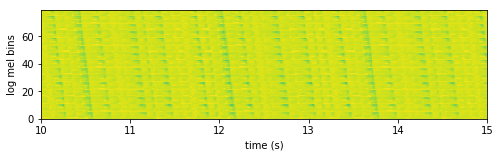

In [50]:
plt.figure(figsize=(8,2))
y = np.arange(0, 80)
x = np.arange(0, log_mel.shape[0]) * 0.01
plt.pcolormesh(x, y, np.transpose(log_mel_re[:, :, 7, 0]))
plt.ylabel('log mel bins')
plt.xlabel('time (s)')
plt.xlim(10, 15)
plt.show()

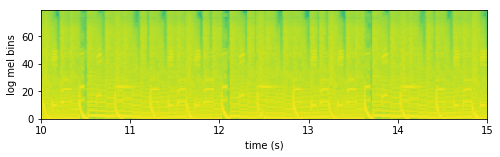

In [38]:
plt.figure(figsize=(8,2))
y = np.arange(0, 80)
x = np.arange(0, log_mel.shape[0]) * 0.01
plt.pcolormesh(x, y, np.transpose(log_mel[:, 80 * 7:80 * 8,0]))
plt.ylabel('log mel bins')
plt.xlabel('time (s)')
plt.xlim(10, 15)
plt.show()